In [1]:
import scanpy as sc

In [2]:
import pickle

In [3]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
import os
from importlib import reload

# Add the path of your package
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/GlossPath/")
sys.path.insert(0, package_path)
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/Gloss/")
sys.path.insert(0, package_path)

In [7]:
def generate_pathways_dict(fn, mygenes, change_case = False):
    pathways = {}
    with open(fn, "r") as f:
        for line in f:
            line = line.strip()
            words = line.split("\t")
            if change_case:
                words = [ word.capitalize() for word in words]
            pathway = words[2:]
            pathway = list(set(pathway).intersection(mygenes))
            pathways[words[0]] = pathway
            #if len(pathway) < 200 and len(pathway) > 3:
            #    pathways[words[0]] = pathway
    return pathways

In [8]:
def get_hallmark_pathways(gene_ad):
    hallmark_pathways_path = '../pathway_collections/mouse_hallmark_genes.gmt.txt'
    mygenes = set(gene_ad.var.index)
    path_dict = generate_pathways_dict(hallmark_pathways_path, mygenes)
    return path_dict

def get_kegg_pathways(gene_ad):
    with open('../pathway_collections/kegg_pathways_sep18_2024.pkl', 'rb') as handle:
        kegg_gene_sets = pickle.load(handle)
    
    mygenes = set(gene_ad.var.index)
    for key, value in kegg_gene_sets.items():
        kegg_gene_sets[key] = list(set([gene for gene in value if gene in mygenes]))
        
    empty = []
    for key in kegg_gene_sets:
        if not kegg_gene_sets[key]:
            empty.append(key)

    for pathway in empty:
        kegg_gene_sets.pop(pathway)
        
    path_dict = kegg_gene_sets
    return path_dict

In [9]:
with open('../pathway_computations/cellchatdb.pickle', 'rb') as handle:
    cellchatdb = pickle.load(handle)
with open('../pathway_computations/cd40neighbors.pickle', 'rb') as handle:
    cd40neighbors = pickle.load(handle)

In [10]:
with open('../pathway_computations/random_neighbors.pickle', 'rb') as handle:
    random_neighbors = pickle.load(handle)

In [11]:
with open('../pathway_computations/humanbase_cd40neighbors.pickle', 'rb') as handle:
    humanbase_cd40neighbors = pickle.load(handle)

In [12]:
with open('../pathway_computations/cd40_filtered.pickle', 'rb') as handle:
    cd40_filtered_neighbors = pickle.load(handle)

In [13]:
from GlossPath.prepdata import PrepData

In [14]:
prepped_datas = {}
for i in range(10):
    print(i)
    datapath = 'datasets/{}_lipstic_tumor_data_perturbed_filtered_v2_oct_25_2024.h5ad'.format(i)
    prepped_datas[i] = PrepData(datapath, 'hallmark', 'hash_max', 'nCount_RNA', 'biotin_raw')

0
1
2
3
4
5
6
7
8
9


In [15]:
l_tumor_adatas = {}
for i in range(10):
    l_tumor_adatas[i] = prepped_datas[i].adata

In [16]:
datasets = {
    #'gut' : gut_ad,
    #'lcmv_sys' : lcmv_sys_ad,
    #'lcmv_ln' : lcmv_ln_ad,
    'l_tumor' : l_tumor_adatas,
}

In [17]:
datasets['l_tumor']

{0: AnnData object with n_obs × n_vars = 10346 × 10898
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.mt.log2', 'nCount_HTO', 'nFeature_HTO', 'nCount_ADT', 'nFeature_ADT', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'Hash', 'Enrichment', 'Ab_Group', 'S.Score', 'G2M.Score', 'Phase', 'Phase2', 'Biotin_Group2', 'Biotin_Ab_Group', 'Lipstic1', 'hash_max', 'hash_id', 'biotin_raw', 'n_counts', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'annotation', 'annotation_fine', 'biotin_raw_perturbed'
     var: 'name', 'n_counts', 'mean', 'std'
     uns: 'log1p', 'pearson_residuals_normalization'
     obsm: 'X_pca', 'X_umap'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled',


In [18]:
## coefficients

# uLIPSTIC gut
#with open('../model_ulipstic_gut/experiment_evaluations/gut_glosspath_bootstrap_hallmark_oct9_2024.pickle', 'rb') as handle:
#    gut_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv sys
#with open('../model_ulipstic_lcmv/experiment_evaluations/', 'rb') as handle:
#    lcmv_sys_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv ln
#with open('../model_ulipstic_lcmv/experiment_evaluations/grouplasso_hallmark_bootstrap_u_lcmv_ln_oct3_2024.pickle', 'rb') as handle:
#    lcmv_ln_glasso_res = pickle.load(handle)
# LIPSTIC tumor

lipstic_tumor_perturb_bootstraps = {}
for i in range(10):
    print(i)
    with open('../model_lipstic_tumor/experiment_evaluations/{}_tumor_perturbed_filtered_v2_control_new_glosspath_bootstrap_hallmark_oct26_2024.pickle'.format(i), 'rb') as handle:
        lipstic_tumor_perturb_bootstraps[i] = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9


In [19]:
l_tumor_coefficient_results = {}
for i in range(10):
    l_tumor_coefficient_results[i] = lipstic_tumor_perturb_bootstraps[i].response_individual_genes

In [20]:
coefficient_results = {
    #'gut' : gut_glasso_res.response_individual_genes,
    #'lcmv_sys' : lcmv_sys_glasso_res,
    #'lcmv_ln' : lcmv_ln_glasso_res,
    'l_tumor' : l_tumor_coefficient_results
}

In [21]:
resolution_subsets = {

'l_tumor' : {
    'annotation_fine' : ['Mo/MF', 'cDC2', 'mRegDC2']
}

}

In [22]:
def make_corr_df(ad, norm_layer, biotin_norm=False):
    genes = ad.var_names
    spearman_rhos = []
    gene_vals = ad.layers[norm_layer].toarray()
    print(gene_vals.shape)
    if not biotin_norm:
        biotin_vals = ad.obs['new_biotin']
    else:
        biotin_vals = ad.obs['other_new_biotin']
    for i, g in enumerate(genes):
        mygene = gene_vals[:,i]
        spearman_rhos.append(spearmanr(biotin_vals, mygene))
    df = pd.DataFrame({"gene": genes, 
                       "corr": [ c[0] for c in spearman_rhos],
                       "sig": [ c[1] for c in spearman_rhos],
                      })
    
    df["top gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=10)["gene"]) + 
    list(df.sort_values("corr", ascending=True).head(n=10)["gene"]))
    df["top 30 corr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=30)["gene"]))
    df["top 30 anticorr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=True).head(n=30)["gene"]))
    df = df.sort_values("corr") 
    df["i"] = [i/10 for i in range(len(genes))]
    
    df['is_FDR_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[0]
    df['corrected_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[1]
    df.dropna(inplace=True)
    return df

In [23]:
datasets['l_tumor']

{0: AnnData object with n_obs × n_vars = 10346 × 10898
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.mt.log2', 'nCount_HTO', 'nFeature_HTO', 'nCount_ADT', 'nFeature_ADT', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'Hash', 'Enrichment', 'Ab_Group', 'S.Score', 'G2M.Score', 'Phase', 'Phase2', 'Biotin_Group2', 'Biotin_Ab_Group', 'Lipstic1', 'hash_max', 'hash_id', 'biotin_raw', 'n_counts', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'annotation', 'annotation_fine', 'biotin_raw_perturbed'
     var: 'name', 'n_counts', 'mean', 'std'
     uns: 'log1p', 'pearson_residuals_normalization'
     obsm: 'X_pca', 'X_umap'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled',


In [24]:
corr_results = {}

for i in range(10):
    print(i)
    corr_results[i] = {}
    for data in resolution_subsets:
        print(data)
        corr_results[i][data] = {}
        for resolution in resolution_subsets[data]:
            corr_results[i][data][resolution] = {}
            for ctype in resolution_subsets[data][resolution]:
                corr_results[i][data][resolution][ctype] = make_corr_df(datasets[data][i][datasets[data][i].obs[resolution] == ctype], norm_layer='log_lib_norm', biotin_norm=True)

0
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


5
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


6
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


7
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


8
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


9
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [25]:
corr_results

{0: {'l_tumor': {'annotation_fine': {'Mo/MF':           gene      corr           sig  top gene  top 30 corr gene  \
    4539      Rps9 -0.217174  1.015385e-29      True             False   
    3223   Alox5ap -0.194403  4.950632e-24      True             False   
    6486      Ear2 -0.184483  9.201669e-22      True             False   
    6385      Tpt1 -0.171033  6.945788e-19      True             False   
    10243    Rps14 -0.163442  2.325053e-17      True             False   
    ...        ...       ...           ...       ...               ...   
    1025      Ass1  0.226474  3.073777e-32      True              True   
    3425     Cxcl9  0.228711  7.325409e-33      True              True   
    821      Procr  0.230053  3.073079e-33      True              True   
    1128      Cd40  0.230255  2.695133e-33      True              True   
    7850    Cxcl16  0.250809  2.212316e-39      True              True   
    
           top 30 anticorr gene       i  is_FDR_sig  corrected_si

In [54]:
dataset = 'l_tumor'
res = 'annotation_fine'
ctype = 'Mo/MF'

In [55]:
i = 0

In [56]:
# filter a dict to only include genes in that data

test_ad = datasets[dataset][i]
coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
corr = corr_results[i][dataset][res][ctype]

# run the enrichment over correlations or coefficients

In [57]:
mycoefs = coef 
mycoefs.columns[-50:]

Index(['Sdhc', 'Tap1', 'Serpine1', 'Nme1', 'Htra4', 'Dld', 'Fgl2', 'Lpl',
       'Gadd45b', 'Olr1', 'Klf6', 'AA467197', 'Mdh2', 'Timp1', 'Procr',
       'Cd274', 'Anpep', 'Sdc4', 'Ccrl2', 'Adam9', 'Psmb9', 'Irf7', 'Cdkn1a',
       'Irf8', 'Aco2', 'Pfkp', 'Vcam1', 'Arhgap10', 'Ccnd2', 'Il4ra', 'Icam1',
       'Tnfaip2', 'Irf1', 'B2m', 'Pf4', 'Nampt', 'Stat1', 'Vdr', 'Ccl5',
       'Basp1', 'Cfb', 'Sod2', 'Hif1a', 'Upp1', 'Inhba', 'Psmb10', 'Cd40',
       'Cxcl9', 'C3', 'Cxcl16'],
      dtype='object')

In [58]:
mypathdict = {}
mypathdict.update(cd40neighbors.copy())
mypathdict.update(cellchatdb.copy())
mypathdict.update(humanbase_cd40neighbors.copy())
mypathdict.update(random_neighbors.copy())
mypathdict.update(cd40_filtered_neighbors.copy())

for key in mypathdict:
    mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))

In [59]:
mypathdict

{'cd40_and_neighbors': ['Pdcd1',
  'Src',
  'Cap1',
  'Alox5',
  'Mapre1',
  'Tlr3',
  'Dym',
  'Rbpj',
  'Antxr2',
  'Il23r',
  'Cd80',
  'Caml',
  'Ncf4',
  'Ciita',
  'Map3k8',
  'Il2ra',
  'Nelfcd',
  'Sgk1',
  'Faf1',
  'Cdk1',
  'Pik3ca',
  'Cd244a',
  'Rnf31',
  'Sell',
  'Myd88',
  'Pik3cg',
  'Usp15',
  'Casp2',
  'Ctnnd1',
  'Slc7a1',
  'Mcm6',
  'Irf5',
  'Map3k7',
  'Ncoa1',
  'Thbd',
  'Tnfrsf11a',
  'Lrp1',
  'Slc39a7',
  'Diablo',
  'Ripk2',
  'Mthfd1',
  'Fig4',
  'Tlr9',
  'Tradd',
  'Ece1',
  'Ppp1r13b',
  'P4ha2',
  'Ly75',
  'Btla',
  'Pou2f2',
  'Cd86',
  'Nfkbiz',
  'Actg1',
  'Ltbr',
  'Mybbp1a',
  'Hras',
  'Gusb',
  'Rhoa',
  'Lyn',
  'Ripk1',
  'Itgb1bp1',
  'Insig2',
  'Erp44',
  'Htra2',
  'Stat4',
  'Scarb2',
  'Ncoa6',
  'Bag3',
  'Ogt',
  'Jak3',
  'Tpt1',
  'Naip2',
  'Cd38',
  'Adora2a',
  'Chuk',
  'Traf3',
  'Scarb1',
  'Tnfrsf18',
  'Ikbkg',
  'Wrn',
  'Hspa1b',
  'Dctn2',
  'Entpd6',
  'Tnfaip3',
  'Bcr',
  'Ccr5',
  'Uggt1',
  'Slc39a13',
  'Ptprs'

In [60]:
import gseapy as gp

# Define your custom local gene sets as a dictionary
gene_sets = mypathdict

In [61]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection'])

In [62]:
pos_coef_dict = {}
pos_corr_dict = {}

pos_coef_sig_dict = {}

for i in range(10):
    print(i)
    
    test_ad = datasets[dataset][i]
    coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
    corr = corr_results[i][dataset][res][ctype]
    
    mycoefs = coef 
    
    mypathdict = {}
    mypathdict.update(cd40neighbors.copy())
    mypathdict.update(cellchatdb.copy())
    mypathdict.update(humanbase_cd40neighbors.copy())
    mypathdict.update(random_neighbors.copy())
    mypathdict.update(cd40_filtered_neighbors.copy())

    for key in mypathdict:
        mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))
    
    pos_coef_dict[i] = {}
    pos_corr_dict[i] = {}

    pos_coef_sig_dict[i] = {}

    for key in mypathdict:
        pos_coef_dict[i][key] = []
        pos_corr_dict[i][key] = []
        pos_coef_sig_dict[i][key] = []

    for total_genes in range(50, 1010, 10):

        gene_list = list(mycoefs.columns[-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        genr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(genr.results['Term'], genr.results['Overlap']))
        overlap_sig_res = dict(zip(genr.results['Term'], genr.results['P-value']))
        for key in gene_sets:
            if key in overlap_res:
                pos_coef_dict[i][key].append(int(overlap_res[key].split('/')[0]))
                pos_coef_sig_dict[i][key].append(overlap_sig_res[key])
            else:
                pos_coef_dict[i][key].append(0)
                pos_coef_sig_dict[i][key].append(1.0)

        overlap_res

        gene_list = list(corr['gene'][-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        cenr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(cenr.results['Term'], cenr.results['Overlap']))
        for key in gene_sets:
            if key in overlap_res:
                pos_corr_dict[i][key].append(int(overlap_res[key].split('/')[0]))
            else:
                pos_corr_dict[i][key].append(0)

0
1
2
3
4
5
6
7
8
9


In [63]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection'])

In [64]:
import pickle

with open('./perturb_v2_control_MoMF.pickle', 'wb') as handle:
    pickle.dump(pos_coef_dict, handle, protocol=4)

In [65]:
mykey = 'cd40_f_in'

In [66]:
myindex = 45
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey][myindex])

coef_overlap

corr_overlap

mydf = pd.DataFrame({'Gloss' : coef_overlap, 'Corr.' : corr_overlap})

from scipy.stats import ttest_rel
mytres = ttest_rel(mydf['Gloss'], mydf['Corr.'])[1]

Text(0.5, 1.0, 'mRegDC2 Control ($p = $8.42e-07, 500 Genes)')

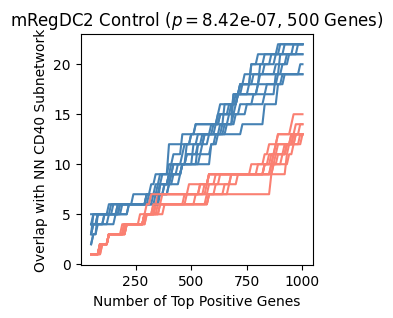

In [39]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with NN CD40 Subnetwork'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'{ctype} Control ($p = ${mytres:.2e}, 500 Genes)'.format(ctype))

Text(0.5, 1.0, 'cDC2 ($p = $2.09e-05, 500 Genes)')

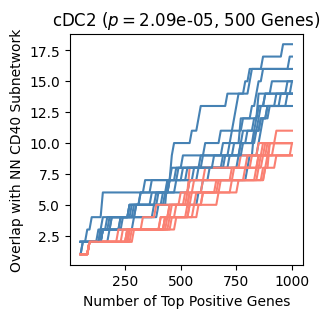

In [53]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with NN CD40 Subnetwork'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'{ctype} ($p = ${mytres:.2e}, 500 Genes)'.format(ctype))

Text(0.5, 1.0, 'Mo/MF Control ($p = $1.86e-10, 500 Genes)')

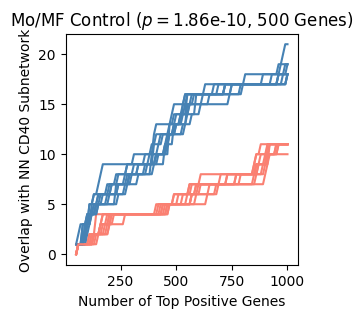

In [67]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with NN CD40 Subnetwork'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'{ctype} Control ($p = ${mytres:.2e}, 500 Genes)'.format(ctype))